In [803]:
#Импорт всех необходимых библиотек
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from scipy.stats import norm
from scipy import stats
import xgboost
import catboost
from sklearn.metrics import r2_score
import pandas as pd
import seaborn as sns
%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import re
import ast

In [804]:
data = pd.read_csv('data.csv')
#Посмотрим на данные
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [805]:
#Посмотрим столбцы
print(data.columns)

Index(['status', 'private pool', 'propertyType', 'street', 'baths',
       'homeFacts', 'fireplace', 'city', 'schools', 'sqft', 'zipcode', 'beds',
       'state', 'stories', 'mls-id', 'PrivatePool', 'MlsId', 'target'],
      dtype='object')
 
Я сразу решил избавиться от некоторых столбов по следующим причинам:
private pool - копия PrivatePool (к тому же больше пропущенных значений
MlsId и mls-id столбцы для риэлторов. Они не нужны
Из city, street и zipcode вряд ли получится что то получить


In [806]:
data = data.drop(['MlsId', 'mls-id', 'private pool', 'city', 'street', 'zipcode'], axis = 1)

In [807]:
#Процентное отношение пропущеных данных ко всем
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data)

               Total   Percent
PrivatePool   336874  0.893127
fireplace     274070  0.726620
stories       150715  0.399578
baths         106338  0.281925
beds           91282  0.242009
sqft           40577  0.107579
status         39918  0.105831
propertyType   34733  0.092085
target          2481  0.006578
state              0  0.000000
schools            0  0.000000
homeFacts          0  0.000000


In [808]:
#Для начала, нужно максимально обработать все столбцы
#Посмотрим на пример данных в PrivatePool
print(data['PrivatePool'].unique())

[nan 'yes' 'Yes']
В данном случае nan означает отсутствие бассейна
Заменим yes на 1 а nan на 0


In [809]:
def func_pool(x):
    if type(x) != int:
        x = x.replace(x, '1')
    return int(x)

data['PrivatePool'] = data['PrivatePool'].fillna(0).apply(func_pool)

In [810]:
print(data['fireplace'].unique())

['Gas Logs' nan 'yes' ...
 'Ceiling Fan, Fire Sprinkler System, Storage, Utility Connection'
 'Fireplace-Gas, Fireplace-Wood, Patio, Walk-in Closet'
 'Ceiling Fan, SMAPL, Utility Connection, Walk-In Closets']
 
Аналогично бассейну


In [811]:
def func_fire(x):
    if type(x) != int:
        x = x.replace(x, '1')
    return int(x)

data['fireplace'] = data['fireplace'].fillna(0).apply(func_fire)

In [812]:
#Рассмотрим stories
print(data['stories'].unique())

[nan '2.0' '1.0' '3.0' 'One' '2' 'Multi/Split' '4.0' '0.0' '0' 'One Level'
 '1' '9.0' '3' '1 Level, Site Built' 'One Story' '3.00' '1.00' '14.0'
 'Two' '3+' '1 Story' '5.0' '2 Story' 'Ranch/1 Story' 'Condominium'
 'Stories/Levels' '7.0' '2 Level, Site Built' '2 Level' '15'
 '3 Level, Site Built' '4' '22.0' '2.00' '6.0' '1.0000' 'Lot' '3 Story'
 'Three Or More' '1.5' '1 Level' 'Two Story or More'
 'Site Built, Tri-Level' '54.0' '23' 'Farm House' '8.0' '16.0' '1.50' '18'
 '9' '21' '8' '12.0' 'Split Level w/ Sub' '11.0' '18.0' '1.5 Stories' '7'
 '11' 'Townhouse' '12' '21.0' '16' '1.5 Story/Basement' '28.0'
 'Traditional' '2.5 Story' '17' '2.0000' '63.0' 'Acreage'
 'Ground Level, One' '6' 'Split Foyer' '2 Stories' '27.0' '19.0' '2.50'
 '1.30' '2 Story/Basement' 'Split Level' '1.5 Story' '1.5 Level'
 '2 Or More Stories' '1 Level, Condo, Site Built' '15.0' '20' '1.5000'
 '4.00' '1 Story Basement' '5' 'Multi-Level' '17.0' 'Other Multi-unit'
 'Ranch' 'Tri-Level' '13.0' '1 Story/Ranch' '51.0' '

In [813]:
#Видно, что формат данных в этом столбце очень разнообразен
#Вытащим из строк первое попавшееся число
#будем считать, что дом одноэтажный если этаж не дан

def func_stor(x):
    if type(x) != int:
        x = re.findall(r'\d+',x)
        if (len(x) > 1):
            x = x[0]
        elif len(x) == 1:
            x = x[0]
        if not x:
            return 1
    return int(x)

data['stories'] = data['stories'].fillna(1).apply(func_stor)
data['stories'] = pd.to_numeric(data['stories'])

In [814]:
#Взглянем на baths
print(data['baths'].unique())

['3.5' '3 Baths' '2 Baths' '8 Baths' nan '2' '3' 'Bathrooms: 2' '1,750'
 '4 Baths' '2 ba' 'Bathrooms: 5' '1,000' '7 Baths' '2.0' '3.0'
 'Bathrooms: 1' '4.0' '2.1 Baths' '2.5 Baths' '1' 'Bathrooms: 3' '4.5'
 '6 Baths' 'Bathrooms: 4' '3 ba' '5' '2,500' '5.5 Baths' '1.0' '5 Baths'
 '1.5' '4' '~' '2.5' '4,000' '3.5 Baths' '2,000' '3,000' '8.0' '1 ba'
 '3.5 ba' '0' '5.0' '1,500' '7.0' '1,250' '9 Baths' '2,250' '6.0'
 '12 Baths' '5.5' '3,500' '1.5 Baths' '2,750' 'Bathrooms: 6' '4.5 Baths'
 '750' '5.5+' '6' '10 Baths' '6 ba' 'Bathrooms: 19' '10.0' '1.5 ba' '4 ba'
 '12 ba' '2.5+' '8' '7.5+' 'Bathrooms: 10' '0 / 0' 'Sq. Ft. ' '5 ba'
 '4.5+' '18 Baths' '-- baths' 'Bathrooms: 7' '7' '18' '3.5+' '1.5+'
 '11 Baths' '5,000' '1.75 Baths' '9' '12.0' '1.1 Baths' '6.5'
 'Bathrooms: 8' '10' '19 Baths' 'Bathrooms: 9' '16 Baths' '13 Baths'
 'Bathrooms: 13' '14' '9.0' '8.5+' '7 ba' '12' '2.5 ba' 'Bathrooms: 12'
 '17' 'Bathrooms: 241' '16.0' '10.5+' '8 ba' '6.5+' '6.5 Baths' '14 Baths'
 '7,500+' '7.5' '11.0'

In [815]:
#Аналогично stories
def func_bath(x):
    if type(x) != int:
        x = re.findall(r'\d+',x)
        if (len(x) > 1):
            x = x[0]
        elif len(x) == 1:
            x = x[0]
        if not x:
            return 1
    return int(x)

data['baths'] = data['baths'].fillna(1).apply(func_bath)

In [816]:
#Взглянем на beds
print(data['beds'].unique())

['4' '3 Beds' '5 Beds' ... '9,565 sqft' '1.74 acres' '8,479 sqft']


In [817]:
#Аналогично stories и baths
def func_bed(x):
    if type(x) != int:
        x = re.findall(r'\d+',x)
        if (len(x) > 1):
            x = x[0]
        elif len(x) == 1:
            x = x[0]
        if not x:
            return 1
    return int(x)

data['beds'] = data['beds'].fillna(1).apply(func_bed)

In [818]:
#Взгялем на status
print(data['status'].unique())

['Active' 'for sale' nan 'New construction' 'New' 'For sale' 'Pending' 'P'
 'Active/Contingent' 'Pre-foreclosure / auction' ' / auction'
 'Under Contract' 'Under Contract   Showing' 'Pre-foreclosure'
 'Under Contract Backups' 'foreclosure' 'Active Under Contract'
 'Foreclosed' 'Option Pending' 'Under Contract Show' 'for rent' 'Auction'
 'A Active' 'Contingent' 'Pending   Continue To Show' 'Price Change'
 'Back on Market' 'Active Option' 'Foreclosure' 'recently sold'
 'Coming soon: Nov 21.' 'Contingent Finance And Inspection'
 'Coming soon: Dec 4.' 'P Pending Sale' 'Coming soon: Nov 23.'
 'Active With Contingencies' 'Pending Ab' 'Pf' 'Contingent Show'
 'Contract P' 'Contingent Take Backup' 'Apartment for rent'
 'Backup Contract' 'Option Contract' 'Pending Continue To Show' 'pending'
 'Pending Inspection' 'Active Option Contract' 'C' 'Auction - Active'
 'Contingent   Show' 'Pi' 'Due Diligence Period'
 'Contract Contingent On Buyer Sale' 'U Under Contract'
 'Coming soon: Nov 29.' 'Coming 

In [819]:
#Взглянем на propertyType
print(data['propertyType'].unique())

['Single Family Home' 'single-family home' 'lot/land' ...
 'Cabin/Lodge, Contemporary, Converted Barn, Cottage, Loft with Bedrooms, Log Home, Post & Beam'
 'Lake House, Single Detached, Tudor'
 'Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit']
 
Эти 2 столбца будет очень тяжело обработать
Удалим их


In [820]:
data = data.drop(['propertyType', 'status'], axis=1)

Удалим строки с пропущеными значениями в target и sqft


In [821]:
data = data.drop(data.loc[data['target'].isnull()].index)
data = data.drop(data.loc[data['sqft'].isnull()].index)

Убедимся, что пропущеных данных больше нет


In [822]:
print(data.isnull().sum().max())

0
 
Взглянем на шапку


In [823]:
data.head()

,baths,homeFacts,fireplace,schools,sqft,beds,state,stories,PrivatePool,target
0,3,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",1,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,4,NC,1,0,"$418,000"
1,3,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",0,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",3,WA,2,0,"$310,000"
2,2,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",1,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",3,CA,1,1,"$2,895,000"
3,8,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",1,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",5,TX,3,0,"$2,395,000"
5,1,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",0,"[{'rating': [], 'data': {'Distance': [], 'Grad...",897 sqft,2,PA,2,0,"$209,000"


In [824]:
#Приведем target и sqft к int

def func_cost(x):
    if type(x) != int:
        x = re.findall(r'\d+',x)
        if len(x) > 2:
            x = x[0] + x[1] + x[2]
        elif len(x) > 1:
            x = x[0] + x[1]
        elif len(x) == 1:
            x = x[0]
        if not x:
            return np.nan
    return int(x)

def func_area(x):
    if type(x) != int:
        x = re.findall(r'\d+',x)
        if len(x) > 1:
            x = x[0] + x[1]
        elif len(x) == 1:
            x = x[0]
        if not x:
            return np.nan
    return int(x)

data['sqft'] = data['sqft'].apply(func_area)
data['target'] = data['target'].apply(func_cost)
# Вновь удалим строки с пропущенными значениями
# Функция может вернуть NaN
data = data.drop(data.loc[data['target'].isnull()].index)
data = data.drop(data.loc[data['sqft'].isnull()].index)

Посмотрим на homeFacts


In [825]:
print(data['homeFacts'][0])
print(type(data['homeFacts'][0]))

{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}
<class 'str'>

Видно, что эти строки представляют собой словарь, но в типе str
Преобразуем в dict


In [826]:
ex = ast.literal_eval(data['homeFacts'][0])
print(ex)
print('Тип данных: {}'.format(type(ex)))

{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}

Тип данных: <class 'dict'>
Достанем данные из этих строк


In [827]:
def data_func1(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][0].get('factValue')

def data_func2(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][1].get('factValue')

def data_func3(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][2].get('factValue')

def data_func4(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][3].get('factValue')

def data_func5(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][4].get('factValue')

def data_func6(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][5].get('factValue')

def data_func7(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][6].get('factValue')

data['built'] = data['homeFacts'].apply(data_func1)
data['rebuilt'] = data['homeFacts'].apply(data_func2)
data['heating'] = data['homeFacts'].apply(data_func3)
data['cooling'] = data['homeFacts'].apply(data_func4)
data['parking'] = data['homeFacts'].apply(data_func5)
data['lotsize'] = data['homeFacts'].apply(data_func6)
data['price'] = data['homeFacts'].apply(data_func7)
# built - год постройки
# rebuilt - год реновации
# heating - отопление
# cooling - кондиционер
# parking - паркинг
# lotsize - площадь участка
# price - цена за 1 sqft

Обрабатываем schools аналогично homeFacts
Возьмем расстояние до ближайшей школы


In [828]:
print(data['schools'][0])
print(' ')
print(type(data['schools'][0]))

[{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR'], 'data': {'Distance': ['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5 mi', '12.6 mi', '2.7 mi', '3.1 mi'], 'Grades': ['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12']}, 'name': ['Southern Pines Elementary School', 'Southern Middle School', 'Pinecrest High School', 'Southern Pines Primary School', "Crain's Creek Middle School", 'Union Pines High School', 'Episcopal Day Private School', 'Calvary Christian Private School']}]
 
<class 'str'>


In [829]:
def data_func8(x):
    m = []
    a = ast.literal_eval(x)
    a = dict(a[0])
    k = a['data'].get('Distance')
    for i in k:
        h = re.findall(r'\d+',i)
        if len(h) == 0:
            continue
        if len(h) == 1:
            m.append(float(h[0]))
            continue
        d = h[0] + '.' + h[1]
        m.append(float(d))
    if len(m) == 0:
        return np.nan
    else:
        return min(m)
    
data['distance'] = data['schools'].apply(data_func8)
data = data.drop(data.loc[data['distance'].isnull()].index)
#distance - дистанция до ближайшей школы

Отбросим homeFacts и schools. Они нам больше не нужны


In [830]:
data = data.drop(['homeFacts', 'schools'], axis = 1)

Посмотрим на пропуски в новых данных


In [831]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.head(8))

          Total   Percent
lotsize   24571  0.074414
rebuilt   22617  0.068497
price     18547  0.056170
built       569  0.001723
parking     543  0.001644
cooling     543  0.001644
heating     543  0.001644
distance      0  0.000000


In [832]:
#Обработаем parking, cooling, heating
print(data['cooling'].unique())

['' 'Central' 'Central Air' ...
 'Central Air, Electric Hot Air, Gas (Hot Air), Heat Pump for A/C, Heat Pump for Heat, Multi-Zone A/C, Multi-Zone Heat, Natural Gas'
 '90%+ High Efficiency, Ductless HP-Mini Split, Tankless Water Heater'
 'Central A/C (Gas), Central Heat (Gas), Heat Pump']


In [833]:
def func_cool(x):
    if x == '':
        return 0
    return 1

data['cooling'] = data['cooling'].fillna(0).apply(func_cool)

In [834]:
print(data['heating'].unique())

['Central A/C, Heat Pump' '' 'Forced Air' ...
 'Electric Furnace, Electric Heat Pump'
 'Floor Furnace, Wall Electric, Wall Gas'
 'Baseboard, Hot Water, Programmable Thermostat, Radiant Floor']


In [835]:
def func_heat(x):
    if x == '':
        return 0
    return 1

data['heating'] = data['heating'].fillna(0).apply(func_heat)

In [836]:
print(data['parking'].unique())

['' 'Attached Garage' 'Detached Garage' ... 'Basement, Detached'
 'Paved Driveway, Off Street, Detached Garage'
 'Deed Restrictions, Fitness, Gated Community, Golf Carts OK, No Truck/RV/Motorcycle Parking, Pool, Special Community Restrictions']


In [837]:
def func_park(x):
    if x == '':
        return 0
    return 1

data['parking'] = data['parking'].fillna(0).apply(func_park)

Достанем все числа из built


In [838]:
def func_built(x):
    x = re.findall(r'\d+',x)
    if len(x) > 1:
        x = x[0] + x[1]
    elif len(x) == 1:
        x = x[0]
    if not x:
        return np.nan
    return int(x)

#Удаляем строки с пропущеными значениями
data = data.drop(data.loc[data['built'].isnull()].index)
data['built'] = data['built'].apply(func_built)
#Удаляем еще раз так как функция может вернуть NaN
data = data.drop(data.loc[data['built'].isnull()].index)

Обработаем rebuilt следующим образом:
Присвоим пропущеным значениям rebuilt значения built


In [839]:
data['rebuilt'] = data['rebuilt'].fillna(0)
def func_rebuilt(row):
    if row['rebuilt'] == 0:
        return row['built']
    if row['rebuilt'] == '':
        return row['built']
    return row['rebuilt']
        
data['rebuilt'] = data.apply(lambda row: func_rebuilt(row), axis=1)

Взглянем на все, что осталось


In [840]:
data.head()

,baths,fireplace,sqft,beds,state,stories,PrivatePool,target,built,rebuilt,heating,cooling,parking,lotsize,price,distance
0,3,1,2900.0,4,NC,1,0,418000,2019.0,2019,1,0,0,None,$144,2.70
1,3,0,1947.0,3,WA,2,0,310000,2019.0,2019,0,0,0,5828 sqft,$159/sqft,1.01
2,2,1,3000.0,3,CA,1,1,2895000,1961.0,1967,1,1,1,"8,626 sqft",$965/sqft,1.19
3,8,1,6457.0,5,TX,3,0,2395000,2006.0,2006,1,1,1,"8,220 sqft",$371/sqft,0.10
6,1,0,1507.0,1,FL,1,0,181500,2006.0,2006,1,1,0,"4,996 Sq. Ft.",$120 / Sq. Ft.,0.80


In [841]:
#Достанем числа из lotsize и price

def func_lot(x):
    if type(x) != int:
        x = re.findall(r'\d+',x)
        if len(x) > 1:
            x = x[0] + x[1]
        elif len(x) == 1:
            x = x[0]
        if not x:
            return np.nan
    return int(x)

#Отбросим строки с пропусками в lotsize и price из за сложности обработки
data = data.drop(data.loc[data['lotsize'].isnull()].index)
data = data.drop(data.loc[data['price'].isnull()].index)
data['lotsize'] = data['lotsize'].apply(func_lot)
data['price'] = data['price'].apply(func_lot)
data = data.drop(data.loc[data['lotsize'].isnull()].index)
data = data.drop(data.loc[data['price'].isnull()].index)

state я решил обработать следующим образом:
Я заменяю штат на число, в зависимости от группы, которые определил, основываясь на благополучие штата
Списки были созданы по этому сайту
https://www.usnews.com/news/best-states/rankings


In [842]:
top = ['WA', 'NH', 'MN', 'UT', 'VT', 'MD', 'VA', 'MA', 'NE', 'CO', 'WI', 'NJ', 'FL', 'IA', 'ND', 'ID']
mid = ['GA', 'NC', 'CA', 'SD', 'CT', 'KS', 'DE', 'HI', 'NY', 'RI', 'OR', 'MO', 'MT', 'TN', 'WY', 'ME']

def state(x):
    if x in top:
        return 2
    if x in mid:
        return 1
    return 0

data['state'] = data['state'].apply(state)

Первичная очистка от вбросов(максимальные параметры домов)


In [843]:
data = data[data['stories'] < 164]
data = data[data['baths'] < 258]
data = data[data['beds'] < 191]

Взглянем на графики некоторых столбцов


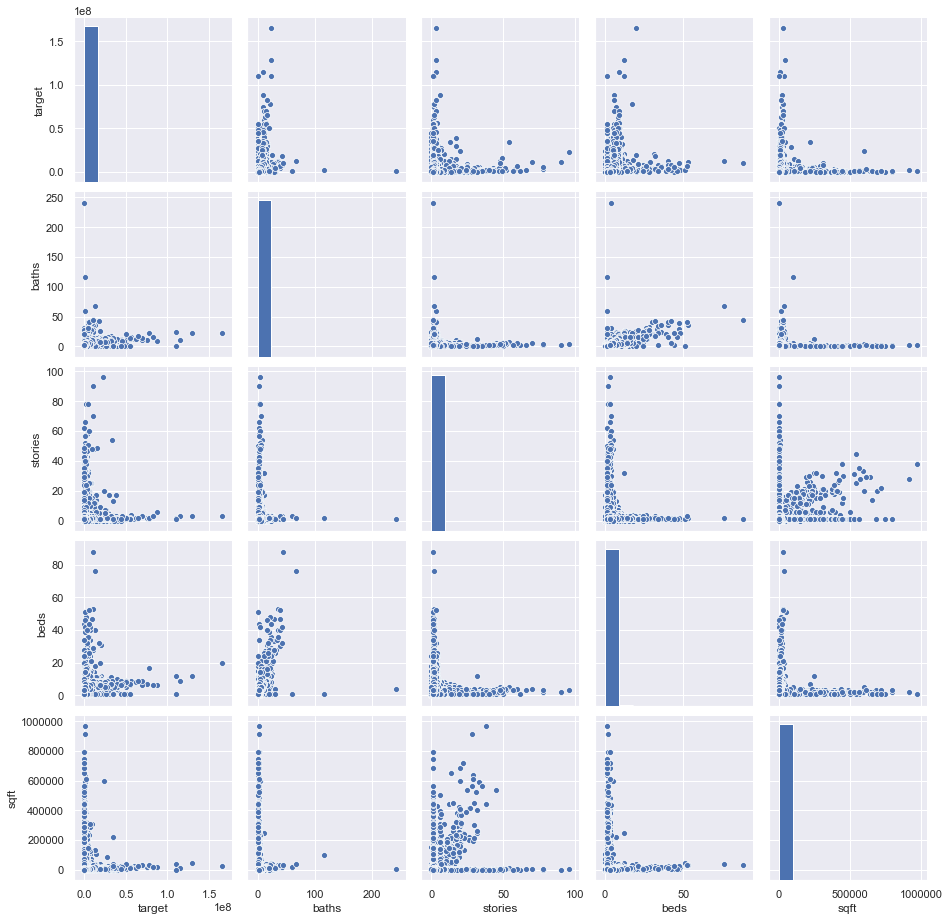

In [844]:
import matplotlib.pyplot as plt
sns.set()
cols = ['target', 'baths', 'stories', 'beds', 'sqft']
sns.pairplot(data[cols], size = 2.5)
plt.show();

target dispersion: 2726869355915.4067


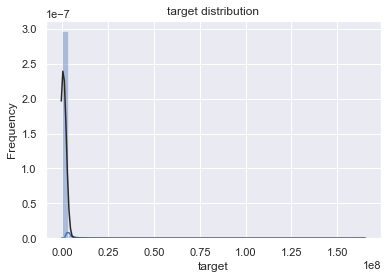

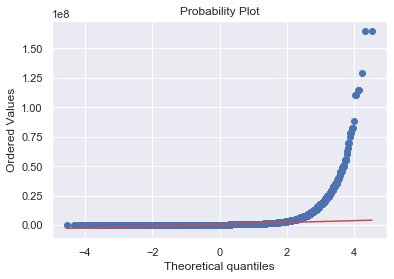

In [845]:
# Посмотрим на распределение и дисперсию целевой переменной
sns.distplot(data['target'] , fit=norm);

plt.ylabel('Frequency')
plt.title('target distribution')

fig = plt.figure()
res = stats.probplot(data['target'], plot=plt)
print('target dispersion: {}'.format(np.var(data['target'])))
plt.show()

sqft dispersion: 158394704.2172877


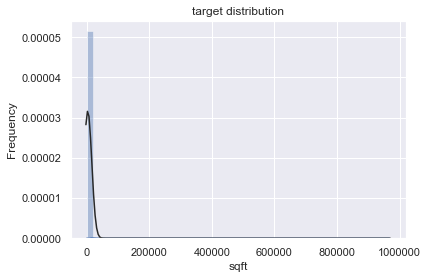

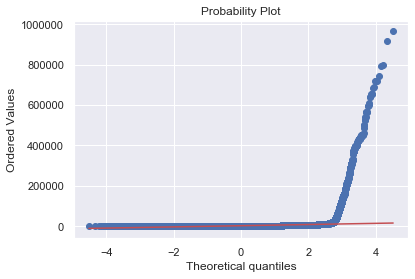

In [846]:
#Проделаем то же самое с sqft
sns.distplot(data['sqft'] , fit=norm);

plt.ylabel('Frequency')
plt.title('target distribution')

fig = plt.figure()
res = stats.probplot(data['sqft'], plot=plt)
print('sqft dispersion: {}'.format(np.var(data['sqft'])))
plt.show()

In [847]:
#Избавимся от лишних данных, основываясь на графики
data = data[data['target'] < 44000000]
data = data[data['sqft'] < 500000]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Из этого графика следует вывод, что продают в основном квартиры или возможно фермы
Очистим все остальные столбцы от вбросов


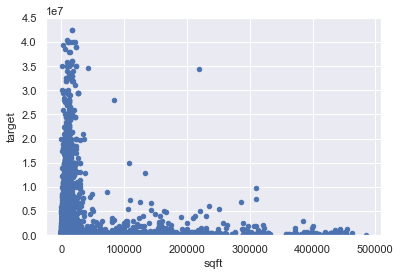

In [848]:
var = 'sqft'
dat = pd.concat([data['target'], data[var]], axis=1)
dat.plot.scatter(x=var, y='target', ylim=(0,45000000));

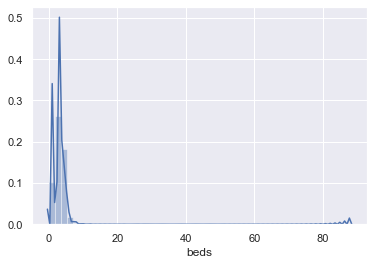

In [849]:
sns.distplot(data['beds'])

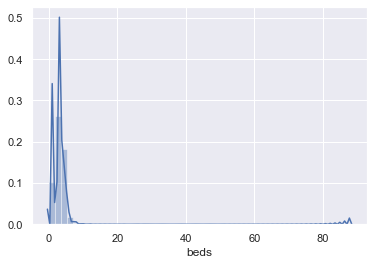

In [850]:
data = data[data['beds'] < 100]
sns.distplot(data['beds'])

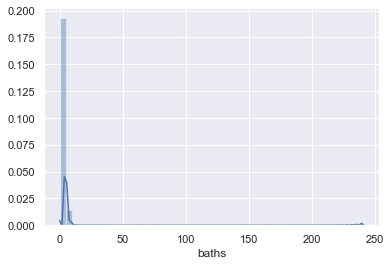

In [851]:
data = data[data['beds'] < 10]
sns.distplot(data['baths'])

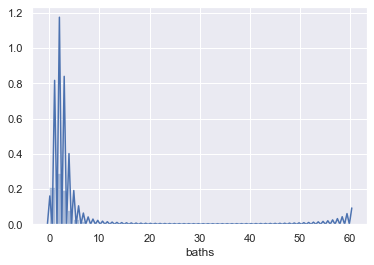

In [852]:
data = data[data['baths'] < 100]
sns.distplot(data['baths'])

In [853]:
data = data[data['baths'] < 10]

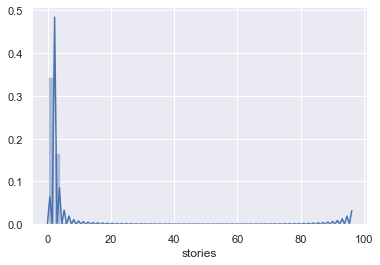

In [854]:
sns.distplot(data['stories'])

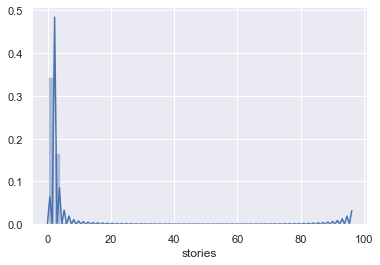

In [855]:
sns.distplot(data['stories'])

In [856]:
data = data[data['stories'] < 15]

#приведем все данные к int на всякий случай
for x in data.columns:
    data[x] = data[x].astype(int)

data.to_csv('model.csv', index=False)

In [857]:
data = pd.read_csv('model.csv')

X = data.drop('target', axis = 1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=21)

Проверим работу некоторых регрессоров


In [858]:
xg = xgboost.XGBRegressor()
scores = cross_val_score(xg, X_train, y_train, cv=cv, n_jobs=-1, scoring='r2')
print("Xgboost: {}/{}".format(scores.mean(), scores.std()))

Xgboost: 0.9846224063545553/0.004225766829977307


In [859]:
lr = LinearRegression()
scores = cross_val_score(lr, X_train, y_train, cv=cv, n_jobs=-1, scoring='r2')
print("LinearRegression: {}/{}".format(scores.mean(), scores.std()))

LinearRegression: 0.2051600612458165/0.002585966129733921


In [860]:
ct = catboost.CatBoostRegressor()
scores = cross_val_score(ct, X_train, y_train, cv=cv, n_jobs=-1, scoring='r2')
print("catboost: {}/{}".format(scores.mean(), scores.std()))

catboost: 0.9357667439817611/0.007319459725030101


In [861]:
gb = GradientBoostingRegressor(random_state=21)
scores = cross_val_score(gb, X_train, y_train, cv=cv, n_jobs=-1, scoring='r2')
print("GradientBoosting: {}/{}".format(scores.mean(), scores.std()))

GradientBoosting: 0.9835067691890673/0.005610745130667921


In [862]:
kn = KNeighborsRegressor()
scores = cross_val_score(kn, X_train, y_train, cv=cv, n_jobs=-1, scoring='r2')
print("Kneighbors: {}/{}".format(scores.mean(), scores.std()))

Kneighbors: 0.8710300681786665/0.013374827022882294


In [863]:
rf = RandomForestRegressor(random_state=21)
scores = cross_val_score(rf, X_train, y_train, cv=cv, n_jobs=-1, scoring='r2')
print("RandomForest: {}/{}".format(scores.mean(), scores.std()))

RandomForest: 0.9826760208195363/0.004430081286989351


In [864]:
dt = DecisionTreeRegressor(random_state=21)
scores = cross_val_score(dt, X_train, y_train, cv=cv, n_jobs=-1, scoring='r2')
print("DecisionTree: {}/{}".format(scores.mean(), scores.std()))

DecisionTree: 0.9755110771887313/0.004703698973218491


In [865]:
dt = LGBMRegressor(random_state=21)
scores = cross_val_score(dt, X_train, y_train, cv=cv, n_jobs=-1, scoring='r2')
print("LGBMRegressor: {}/{}".format(scores.mean(), scores.std()))

LGBMRegressor: 0.9548432623743764/0.006078007214893532

Победил GradientBoosting
Подберем параметры


In [866]:
alg_thrd_model = GradientBoostingRegressor(random_state=21)
alg_thrd_params = [{
    "n_estimators": [75, 150, 250],
    "min_samples_split": [1, 2, 3],
    "min_samples_leaf": [1, 2, 3],
    "max_depth": [4, 5, 6]
}]
alg_thrd_grid = GridSearchCV(alg_thrd_model, alg_thrd_params, cv=cv, refit=True, n_jobs=-1)
alg_thrd_grid.fit(X_train, y_train)
alg_thrd_best = alg_thrd_grid.best_estimator_
print("gradient boosting: {} with params {}"
      .format(alg_thrd_grid.best_score_, alg_thrd_grid.best_params_))
#Можно было бы продолжать подбирать параметры, но у меня не было много времени

gradient boosting: 0.9902902314385419 with params {'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 250}


In [867]:
#Обучим модель
gb = GradientBoostingRegressor(max_depth = 5, min_samples_leaf = 2, 
                               min_samples_split = 2, n_estimators = 300, random_state = 21)

gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
print(r2_score(y_test, gb_pred))

Посмотрим на финальную точность
0.9896770531596953


In [868]:
#Сохраним модель
import pickle
with open('mymodel.pkl', 'wb') as output:
       pickle.dump(gb, output)
X_test.to_csv('example.csv')

In [869]:
#Модель могла предсказать отрицательное значение
#Поменяем все отрицательные значения на положительные
for x in range(len(y_pred)):
    if y_pred[x] < 0:
        y_pred[x] = -y_pred[x]

Сохраним результат


In [870]:
submission = pd.DataFrame({"target": y_pred})
submission.to_csv("submission1.csv", index=False)